## Estimate computational time for each backend for different combination of input parameters

In [ ]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm

n_it = 3
n_n_t = 40
n_n_s = 2200
spars_vec = [0.05, 0.10, 0.5, 1.0]
n_spars = len(spars_vec)
time_grid_sparse = np.empty((n_n_t, n_n_s, n_spars, n_it))
time_grid_dense = np.empty((n_n_t, n_n_s, n_spars, n_it))
time_grid_fft = np.empty((n_n_t, n_n_s, n_spars, n_it))
n_t_vec = range(n_n_t)
n_s_vec = range(n_n_s)

for k in range(n_it):
    print(f"##### Iteration {k} #####")
    for j, spars in enumerate(spars_vec):
        print(f"Sparsity {spars}")
        for n_t in tqdm(n_t_vec):
            st_t = time.time()
            for n_s in n_s_vec:
                data = np.random.rand(1,n_t+1,n_s+1)
                n_f = np.ceil(spars*n_s).astype(int)
                n_p = np.ceil(spars*n_s).astype(int)
                w_f = np.random.rand(n_f)
                w_p = np.random.rand(n_p)
                st = time.time()
                TsirfTransformer = process.TsirfTransformer(wv_0=1, wv_f=w_f, wv_p=w_p, backend="dense")
                out_dense = TsirfTransformer._run(data)
                time_grid_dense[n_t, n_s, j, k] = time.time()-st
                st = time.time()
                TsirfTransformer = process.TsirfTransformer(wv_0=1, wv_f=w_f, wv_p=w_p, backend="sparse")
                out_sparse = TsirfTransformer._run(data)
                time_grid_sparse[n_t, n_s, j, k] = time.time()-st
                st = time.time()
                TsirfTransformer = process.TsirfTransformer(wv_0=1, wv_f=w_f, wv_p=w_p, backend="FFT")
                out_fft = TsirfTransformer._run(data)
                time_grid_fft[n_t, n_s, j, k] = time.time()-st
            np.save("res2_time_grid_dense", time_grid_dense)
            np.save("res2_time_grid_fft", time_grid_fft)
            np.save("res2_time_grid_sparse", time_grid_sparse)


## Fit functions that describes the obtained behavior

In [ ]:
import matplotlib.pyplot as plt
import sys
import numpy as np
from matplotlib import colors
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm

n_it = 3
n_n_t = 40
n_n_s = 2200
spars_vec = [0.05, 0.10, 0.5, 1.0]
n_spars = len(spars_vec)
import matplotlib.pyplot as plt
import numpy as np
time_grid_dense = np.load("res2_time_grid_dense.npy")
time_grid_fft = np.load("res2_time_grid_fft.npy")
time_grid_sparse = np.load("res2_time_grid_sparse.npy")
import matplotlib.patches as mpatches
n_n_t = time_grid_dense.shape[0]
n_n_s = time_grid_dense.shape[1]
n_spars = time_grid_dense.shape[2]
r_s = 0
r_e = n_n_t
c_s = 0
c_e = n_n_s
time_grid_dense_avg = np.mean(time_grid_dense, 3)
time_grid_fft_avg = np.mean(time_grid_fft, 3)
time_grid_sparse_avg = np.mean(time_grid_sparse, 3)


col_dict = {0: "#66c2a5",
            0.5: "#8da0cb",
            1: "#fc8d62"}
cm = colors.ListedColormap([col_dict[x] for x in col_dict.keys()])
norm_bins = np.sort([*col_dict.keys()]) + 0.25
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 0.5)
labels = ['Dense', 'Sparse', 'FFT']
len_lab = len(labels)
norm = colors.BoundaryNorm(norm_bins, len_lab, clip=True)
for j in range(4):
    time_grid_dense_slice = time_grid_dense_avg[:,:,j]
    time_grid_fft_slice = time_grid_fft_avg[:,:,j]
    time_grid_sparse_slice = time_grid_sparse_avg[:,:,j]
    time_grid = np.concatenate((time_grid_dense_slice[...,np.newaxis], time_grid_sparse_slice[...,np.newaxis], time_grid_fft_slice[...,np.newaxis]), axis=2)
    res = np.argmin(time_grid, axis=2).astype(float)/2
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10,6))
    im = plt.imshow(res[r_s:r_e,c_s:c_e], aspect='auto',  interpolation='nearest', origin='lower', cmap=cm, norm=norm)

    plt.clim(0,1)
    plt.xlabel('$\mathregular{N_s}$ (time series lenght)')
    plt.ylabel('$\mathregular{N_t}$ (# of time series)')
    colors = [ im.cmap(im.norm(value)) for value in [0, 0.5, 1]]
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=labels[i]) ) for i in [0, 1, 2] ]
    plt.legend(handles=patches, bbox_to_anchor=(0.99, 0.99))
    plt.title(f"Sparsity {spars_vec[j]*100:.0f} %")
    y_s = np.minimum(0.45*(1+spars_vec[j])/spars_vec[j]*(np.arange(c_e)+400)/np.arange(c_e), 39.5*np.ones((c_e)))
    print(y_s)
    plt.plot(np.arange(c_e), y_s, 'k')
    y_f = np.maximum(np.minimum(np.arange(c_e)*np.arange(c_e)*0.0000045*(1+spars_vec[j])-np.arange(c_e)*np.log(np.arange(c_e))*0.00045*(1+spars_vec[j])+np.log((1+spars_vec[j])), 39.5*np.ones((c_e))), -0.5*np.ones((c_e)))
    plt.plot(np.arange(c_e), y_f, 'k--')
    plt.show()

## Plot the obtained functions to define different regions of applications

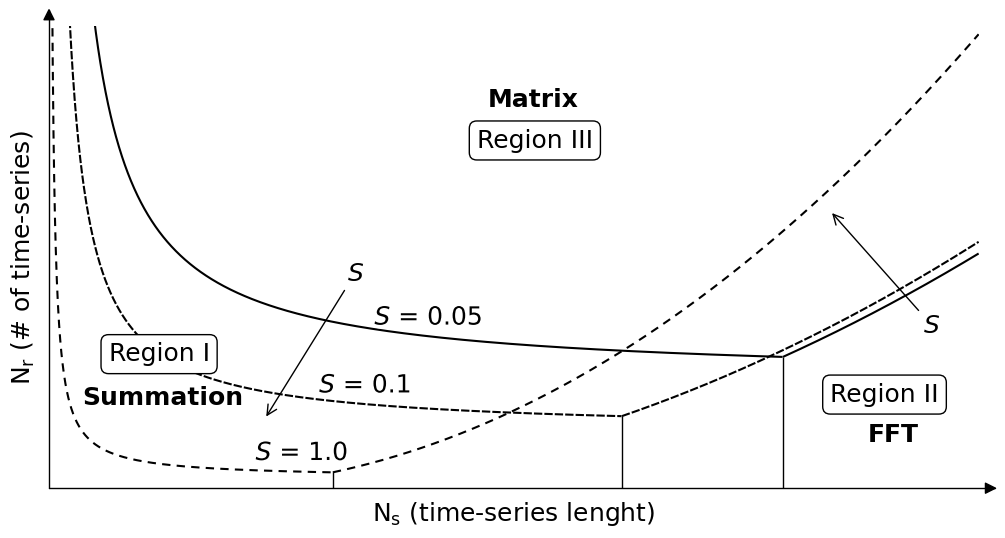

In [6]:
import matplotlib.pyplot as plt
import sys
import numpy as np
from matplotlib import colors
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
np.seterr(divide='ignore', invalid='ignore')

import matplotlib.pyplot as plt
import numpy as np
from labellines import *

r_s = 0
r_e = 40
c_e = 2500

spars_vec = [0.05, 0.10, 0.5, 1.0]
n_spars = len(spars_vec)
from mpl_toolkits.axisartist.axislines import AxesZero
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(axes_class=AxesZero)
for direction in ["xzero", "yzero"]:
    ax.axis[direction].set_axisline_style("-|>")
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    ax.axis[direction].set_visible(False)

plt.rcParams.update({'font.size': 18})
for j in [0, 1, 3]:
    plt.xlabel('$\mathregular{N_s}$ (time series lenght)')
    plt.ylabel('$\mathregular{N_t}$ (# of time series)')
    y_s = 0.45*(1+spars_vec[j])/spars_vec[j]*(np.arange(c_e)+400)/np.arange(c_e)
    y_f = np.maximum(np.arange(c_e)*np.arange(c_e)*0.0000045*(1+spars_vec[j])-np.arange(c_e)*np.log(np.arange(c_e))*0.00045*(1+spars_vec[j])+np.log((1+spars_vec[j])), -0.5*np.ones((c_e)))
    mask_s = y_s > y_f
    mask_f = y_s < y_f
    plt.ylim((0, r_e))
    plt.xlim((0, c_e))
    split = mask_f.argmax(axis=0)
    plt.vlines(split, 0, y_s[split], 'k', linewidth=1)
    plt.plot(np.arange(c_e)[mask_s], y_s[mask_s], color='k', dashes=[4, j], label = f"$S$ = {spars_vec[j]}" )
labelLines(plt.gca().get_lines(), xvals=[1020, 850, 680], align=False, yoffsets=1.6, fontsize=18)
for j in [0, 1, 3]:
    plt.xlabel('$\mathregular{N_s}$ (time-series lenght)')
    plt.ylabel('$\mathregular{N_r}$ (# of time-series)')
    y_s = 0.45*(1+spars_vec[j])/spars_vec[j]*(np.arange(c_e)+400)/np.arange(c_e)
    y_f = np.maximum(np.arange(c_e)*np.arange(c_e)*0.0000045*(1+spars_vec[j])-np.arange(c_e)*np.log(np.arange(c_e))*0.00045*(1+spars_vec[j])+np.log((1+spars_vec[j])), -0.5*np.ones((c_e)))
    mask_s = y_s > y_f
    mask_f = y_s < y_f
    plt.ylim((0, r_e))
    plt.xlim((0, c_e))
    split = mask_f.argmax(axis=0)
    plt.plot(np.arange(c_e)[mask_f], y_f[mask_f], color='k', dashes=[4, j], label = f"{spars_vec[j]}")

plt.text(90, 7.2, 'Summation', fontsize=18, fontweight="bold")
plt.text(1180, 33, 'Matrix', fontsize=18, fontweight="bold")
plt.text(2200, 4, 'FFT', fontsize=18, fontweight="bold")
props = dict(boxstyle='round', edgecolor='black', facecolor='white', fill=True, alpha=1.0)

plt.annotate(f"$S$", xy=(2100, 24), xytext=(2350, 13.5), arrowprops=dict(arrowstyle="->"))
plt.annotate(f"$S$", xy=(580, 6), xytext=(800, 18), arrowprops=dict(arrowstyle="->"))

plt.text(160, 11, 'Region I', fontsize=18, bbox = props)
plt.text(2100, 7.5, 'Region II', fontsize=18, bbox = props)
plt.text(1150, 29.5, 'Region III', fontsize=18, bbox = props)
plt.xticks([], [])
plt.yticks([], [])
plt.savefig(f'regions_dense_fft_sparse.pdf', format="pdf",  bbox_inches="tight")
plt.show()